# Grade: /100 pts
# Assignment 10: FATE Machine Learning

## Student ID: XXXXXXXX

In this coursework, we will study how to make a complex non-linear model more interpretable and we will study any fairness issues that may arise when using AI models to solve organizational problems.

Our problem will be graduate admission,  we'll create a model to predict if a person would be accepted the master program they applied for. The following questions first develop a model, then we study how to make it more interpretable, and finally, we discuss any fairness issues that arise.

In [21]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve,roc_auc_score

from xgboost import XGBClassifier
import shap

For this assignment, we will use a graduate admission dataset. For further information about the data, refer to: https://www.kaggle.com/datasets/mohansacharya/graduate-admissions?resource=download&select=Admission_Predict.csv

**Variables**

1. GRE Scores ( out of 340 )
2. TOEFL Scores ( out of 120 )
3. University Rating ( out of 5 )
4. Statement of Purpose and Letter of Recommendation Strength ( out of 5 )
5. Undergraduate GPA ( out of 10 )
6. Research Experience ( either 0 or 1 )
7. Chance of Admit ( ranging from 0 to 1 )

# Part 1: Data preprocessing and model construction (20 pts)

**Task 1:** Load the data

**Task 2:** Create the target column as 1 if Change of Admit is >0.5 and 0 otherwise

**Task 3:** Drop Chance of Admit, Serial No. and University Rating

**Task 4:** Keep only rows with CGPA values between 8 and 9

**Task 5:** Save the shape in the variable df_shape and print it

**Written question:** Is this dataset imbalanced?

In [3]:
df = pd.read_csv("Admission_Predict.csv")
df["Target"] = (df["Chance of Admit "]>0.65).astype(int)
df.drop(columns=["Serial No.","Chance of Admit ","University Rating"],inplace=True)
df=df[(df.CGPA>=8)&(df.CGPA<=9)]
df_shape = df.shape
print(f"The shape of de Dataframe is {df_shape}")

The shape of de Dataframe is (277, 7)


In [4]:
df.Target.value_counts(normalize=True)

1    0.707581
0    0.292419
Name: Target, dtype: float64

In [5]:
round(df.Target.value_counts()/len(df)*100, 0)

1    71.0
0    29.0
Name: Target, dtype: float64

**Written answer:** The data set is imbalanced since the percentage of accepted is 71.

## Model Construction (30 pts)

**Task 1:** Using all features , split the dataset into training and test sets with `test_size=0.3` and `random_state=0`. (For all later settings, work with this random seed). 

**Task 2:** Construct an xgboost model with the best of the following parameters: 'n_estimators': [250, 300, 350], 'max_depth': [3, 4, 5], 'learning_rate' : [0.001, 0.01, 0.1], 'n_estimators': [50,100,150]. Correctly set the argument `scale_pos_weight`. Check the documentation if needed.

Report the best parameters you found. Save them in a dictionary call best_parameters

**Task 3:** fit the model over the full data using the best parameters you found, plot the roc and report the auc score.

In [6]:
# Task 1: train/test split # 2 pts
x = df.drop(columns=["Target"])
y = df["Target"]


x_train, x_test, y_train, y_test = train_test_split(x, # X
                                                    y,  # y
                                                    test_size = 0.3,           # Size of test
                                                    random_state = 0)   # Seed

In [19]:
y_train.value_counts(normalize=True)

1    0.699482
0    0.300518
Name: Target, dtype: float64

In [20]:
y_test.value_counts(normalize=True)

1    0.72619
0    0.27381
Name: Target, dtype: float64

In [7]:
# Initialize the XGB model # 4pts
model = XGBClassifier(max_depth=3,                  # Depth of each tree
                      learning_rate=0.1,            # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                      n_estimators=100,             # How many trees to use, the more the better, but decrease learning rate if many used.
                      verbosity=1,                  # If to show more errors or not.
                      objective='binary:logistic',  # Type of target variable.
                      booster='gbtree',             # What to boost. Trees in this case.
                      n_jobs=-1,                    # Parallel jobs to run. Set your processor number.
                      scale_pos_weight=81/196,      # Balancing of positive and negative weights.
                      random_state=0                # Seed
                     )

In [8]:
# Define the grid search # 1pt
param_grid = dict({'n_estimators': [250, 300, 350],
                   'max_depth': [3, 4, 5],
                   'learning_rate' : [0.001, 0.01, 0.1],
                   'n_estimators': [50,100,150]
                  })

In [9]:
cv_object = StratifiedKFold(n_splits=3)
# Define grid search object # 2 pts
GridXGB = GridSearchCV(model,        # Original XGB. 
                       param_grid,          # Parameter grid
                       cv = cv_object,      # Cross-validation object.  
                       scoring = 'roc_auc', # How to rank outputs.
                       n_jobs = -1,          # Parallel jobs. -1 is "all you have"
                       refit = False,       # If refit at the end with the best. We'll do it manually.
                       verbose = 1          # If to show what it is doing.
                      )

In [10]:
# Train grid search # 2 pts
GridXGB.fit(x_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     inter...
                                     max_delta_step=None, max_depth=3,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 150]},
             refit=False, scoring='roc_auc', verbose=1)

In [11]:
print(GridXGB.best_params_)

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}


In [12]:
y_train.value_counts()

1    135
0     58
Name: Target, dtype: int64

In [13]:
# model using best parameters # 1 pt
model = XGBClassifier(max_depth=GridXGB.best_params_.get('max_depth'), # Depth of each tree
                      learning_rate=GridXGB.best_params_.get('learning_rate'), # How much to shrink error in each subsequent training. Trade-off with no. estimators.
                      n_estimators=GridXGB.best_params_.get('n_estimators'), # How many trees to use, the more the better, but decrease learning rate if many used.
                      verbosity=1,                  # If to show more errors or not.
                      objective='binary:logistic',  # Type of target variable.
                      booster='gbtree',             # What to boost. Trees in this case.
                      n_jobs=-1,                     # Parallel jobs to run. Set your processor number.
                      scale_pos_weight=58.0/135.0,   # Balancing of positive and negative weights.
                      random_state=0
                     )

In [14]:
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

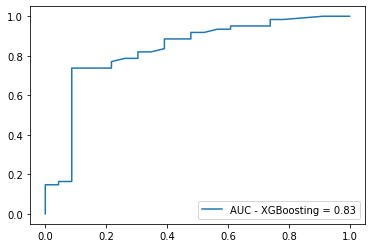

In [15]:
# Plot the precision recall curve # 4 pts
probTest = model.predict_proba(x_test)
probTest = probTest[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, 
                                 probTest)

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = y_test, 
                             y_score = probTest),
               decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="AUC - XGBoosting = " + str(auc))
plt.legend(loc=4)
plt.show()

# Part 2: Feature importance and Interpretability (50 pts)

## Feature Importance (11 pts)

In this part, we compare the variable importance constructed by mean-gini and mean-shap values.

**Task 1:** Plot the variable importance plot by Entropy. 

**Task 2:** Plot the variable importance plot by mean-shap value. 

**Task 3:** Discuss the differences between the variables importance and why do you think it happens. 

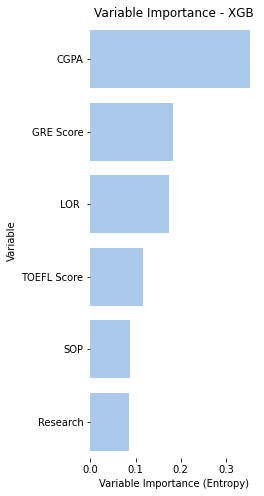

In [16]:
# Task 1: Variable importance using entropy measure #4 pts

importances = model.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - XGB")
sns.set_color_codes("pastel")
sns.barplot(y=[x_train.columns[i] for i in indices], 
            x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Entropy)")
sns.despine(left=True, bottom=True)

In [17]:
df.columns

Index(['GRE Score', 'TOEFL Score', 'SOP', 'LOR ', 'CGPA', 'Research',
       'Target'],
      dtype='object')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


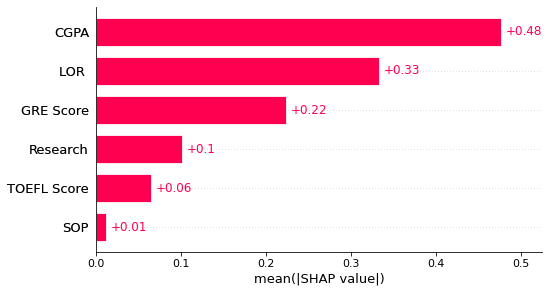

In [18]:
# Task 2: Variable importance by mean-shap values # 3 pts
explainer = shap.Explainer(model, matplotlib=True)
shap_values = explainer(x_train)

shap.plots.bar(shap_values)

**Written Answer 2**: 

The main difference is that GRE score is the less important variable for XGBoost and one of the main variables according to shapley. This is because while the variables in the first plot represent raw predictive power overall, in specific cases, the GRE score causes a bigger shift than the other variables, which is what SHAP is looking for.

## Understanding and interpreting using SHAP values (39 pts)

**Task 1:** explain the model's predictions using SHAP for the first, third and fourth cases in the dataset. What can you conclude from the feature contribution plot? 

**Task 2:** Summarize the effects of all features by using a beeswarm plot. Report the first 3 features and interpret the results. 

**Task 3 :** For each of the variables "GRE Score" and "CGPA", create a Shap-value dependence scatter plot to show the effect of the single feature across the whole dataset.

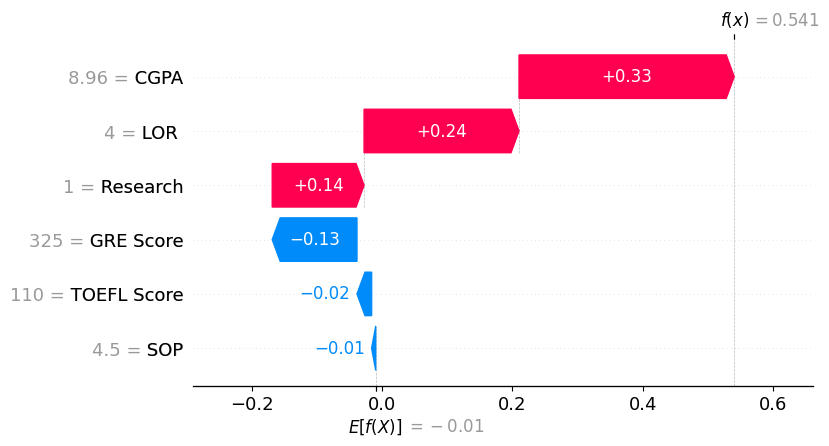

In [40]:
shap.plots.waterfall(shap_values[0])

**Written Answer**: 

We can see that CGPA has the strongest contribution, making all other variables also provide positive value. Overall, this person has all the variables to be accepted.

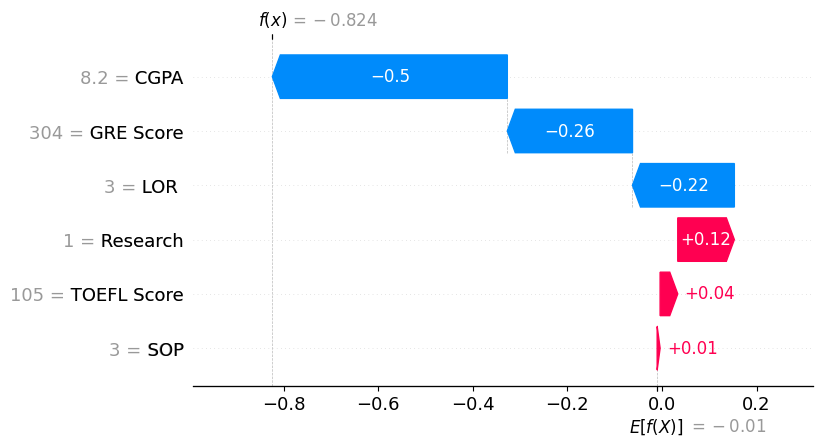

In [41]:
shap.plots.waterfall(shap_values[2])

**Written Answer**: This is a very negative case, almost all features contributes negatively  towards the final classification except Research. This is case is almost sure a non-accepted.

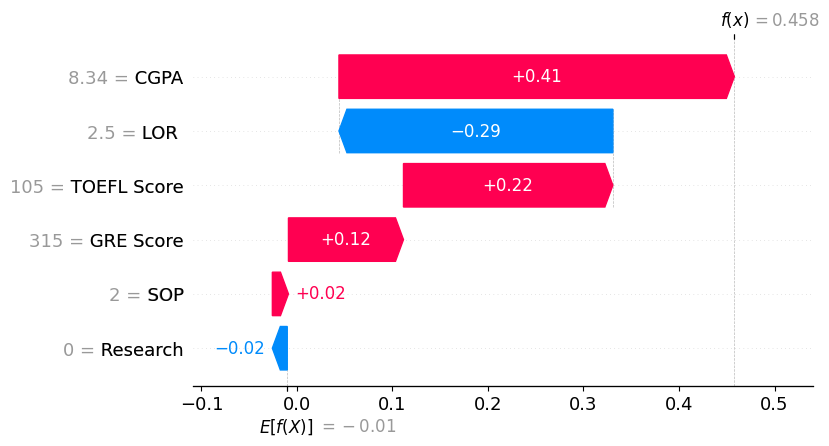

In [42]:
shap.plots.waterfall(shap_values[3])

**Written Answer**: 

The person has a good GRE score but all other variables substract value to the admission. Overall this person is not likely to be accepted since the value of the function is less than the expected value.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


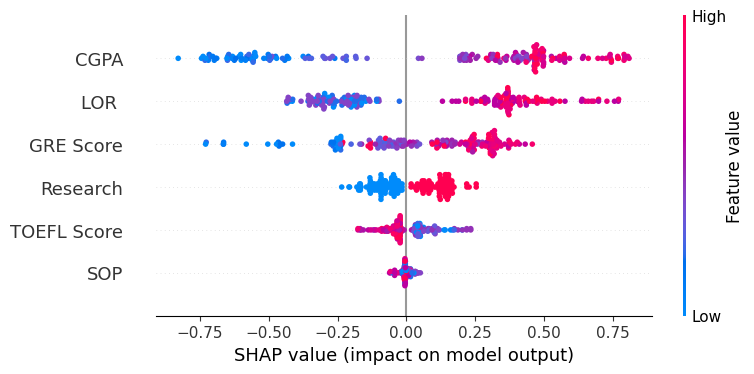

In [43]:
shap.plots.beeswarm(shap_values)

**Written Answer**: 

- CGPA presents the biggest positive contribution for bigger values of the feature. In general, people with high gpa are more likely to get accepted.

- LOR presents a discrete, non-linear behaviour that showcases the strengths of the SHAP approach. Low-medium values of the variable have a small contribution towards making the cases less likely to get accepted. Medium-high values have a slight contribution towards making cases more prone to be classified as a accepted. Very high values present the strongest contribution towards making the case more likely to be accepted.

- GRE Score has the same behavior as LOR with more cases close to 0 and the variable looks more continous.

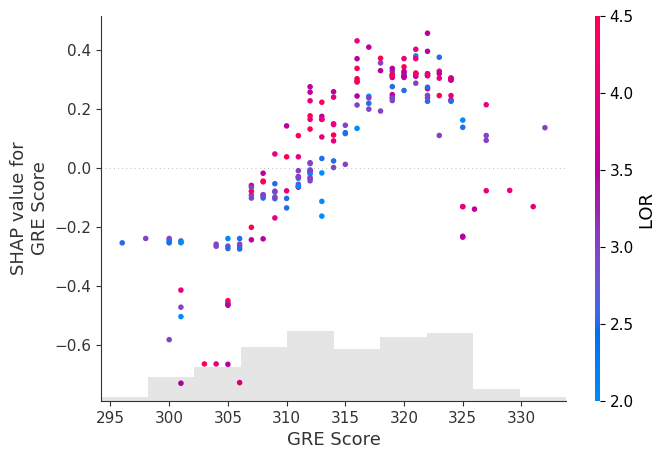

In [44]:
shap.plots.scatter(shap_values[:,"GRE Score"], color=shap_values)

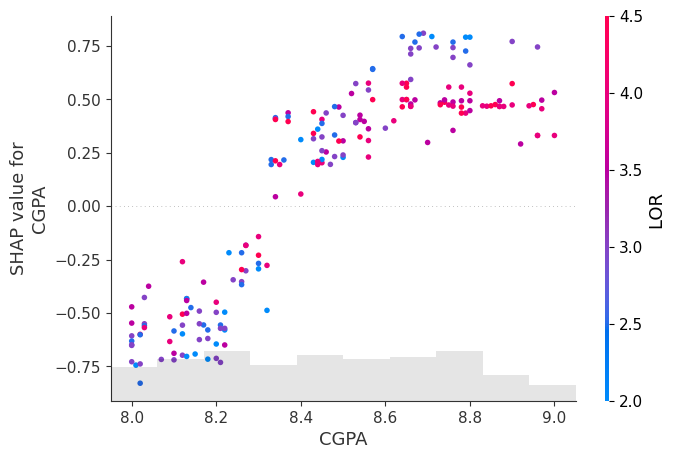

In [45]:
shap.plots.scatter(shap_values[:,"CGPA"], color=shap_values)